In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import os
import sys

try:
    from fluidity_tools import stat_parser as stat
except ImportError:
    # try again by adding the path "../python" relative to testharness' own location to sys.path
    head, tail = os.path.split(sys.argv[0])
    # python_path = os.path.abspath(os.path.join(head, '..', 'python'))
    sys.path.append('/home/gn/Code/fetch2012/fluidity/python')
    from fluidity_tools import stat_parser as stat


import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib2tikz import save as tikz_save

# Make background white
plt.style.use('default')

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
matplotlib.rc('mathtext',**{'default':'regular'})


class ExtractLB:
    def __init__(self):
        self.WALL_T = {}
        self.LB_T = {}
        self.CDOFS = {}

    def get_run_stats(self, dir, log_name, cores):
        """
            Extracts the Load balancer, solver and CDOFs
            out of the stat files, crawling directories following the name
            coreXXX/rad_radiant_noio.e
        """
        # Store the directory before you start
        root_dir = os.getcwd()
        STAT_F = f'{log_name}.Neutron.output_quantities.stat'
        # Use the Fluidity module to load the stat files into arrays
        for cpu in cores:
            os.chdir(f'{dir}/core{cpu}')
            self.LB_T[cpu] = stat(STAT_F)['RadiantLoadBalanceTime']['Value']
            self.WALL_T[cpu] = stat(STAT_F)['ElapsedWallTime']['Value']
            self.CDOFS[cpu] = stat(STAT_F)['ContinuousDOF_per_group']['Value']

        # Change back to the initial directory
        os.chdir(root_dir)

        return self.WALL_T, self.LB_T, self.CDOFS

    def get_partition_stats(self, dir, log_name, max_adapt, num_cores):
        """
        Get the mean and mode partition sizes for each adapt step
        for a given number of processors.

        len(mean_partition_sizes) : max_adapt
        len(mode_partition_sizes) : max_adapt
        len(nodes): max_adapt * num_cores
        """

        # Store the directory before you start
        root_dir = os.getcwd()
        os.chdir(f'{dir}/core{num_cores}')

        # First load the size of partitions from log files
        # You need to checkout archer_loadbalancer branch
        nodes = []
        for i in range(num_cores):
            nodes.extend(np.loadtxt(f'{log_name}.log_{i}', usecols=(1)))

        mean_partition_sizes = []
        mode_partition_sizes = []
        for adapt in range(max_adapt):
            # Gets the average partition size, which should remain constant
            # unless the elements present in the spatial mesh change
            mean_partition_sizes.append(
                sum(nodes[adapt::max_adapt])/len(nodes[adapt::max_adapt]))

            # Calculates the Mode of the partition sizes
            # TODO: write algorithm for multiple modes of an array
            mode_partition_sizes.append(stats.mode(nodes[adapt::max_adapt])[0])

        # Convert to numpy arrays
        mean_partition_sizes = np.asarray(mean_partition_sizes)
        mode_partition_sizes = np.asarray(mode_partition_sizes)
        nodes = np.asarray(nodes)

        # Return to original directory
        os.chdir(root_dir)

        return mean_partition_sizes, mode_partition_sizes, nodes

    def get_halo_stats(self, dir, log_name, max_adapt, num_cores):
        """
        Get the mean and mode of for halo sizes 
        for a given number of processors at every adapt step

        len(mean_halo_sizes) : max_adapt
        len(mode_halo_sizes) : max_adapt
        len(halos): max_adapt * num_cores
        """

        # Store the directory before you start
        root_dir = os.getcwd()
        os.chdir(f'{dir}/core{num_cores}')

        halos = []
        for i in range(num_cores):
            halos.extend(np.loadtxt(f'{log_name}.log_{i}', usecols=(3)))

        mean_halo_sizes = []
        mode_halo_sizes = []
        for adapt in range(max_adapt):
            # Gets the average partition size, which should remain constant
            # unless the elements present in the spatial mesh change
            mean_halo_sizes.append(
                sum(halos[adapt::max_adapt])/len(halos[adapt::max_adapt]))

            # Calculates the Mode of the partition sizes
            # TODO: write algorithm for multiple modes of an array
            mode_halo_sizes.append(stats.mode(halos[adapt::max_adapt])[0])

        # Convert to numpy array
        mean_halo_sizes = np.asarray(mean_halo_sizes)
        mode_halo_sizes = np.asarray(mode_halo_sizes)
        halos = np.asarray(halos)

        # Return to original directory
        os.chdir(root_dir)

        return mean_halo_sizes, mode_halo_sizes, halos

    def get_node_to_halo_ratio_stats(self, dir, log_name, max_adapt, num_cores):
        __, __, halos = self.get_halo_stats(
            dir, log_name, max_adapt, num_cores)
        __, __, nodes = self.get_partition_stats(
            dir, log_name, max_adapt, num_cores)

        ratio = nodes/halos

        mean_ratio = []
        mode_ratio = []
        for adapt in range(MAX_ADAPT):
            mean_ratio.append(
                sum(ratio[adapt::max_adapt])/len(ratio[adapt::max_adapt]))
            mode_ratio.append(stats.mode(ratio[adapt::max_adapt])[0])

        return mean_ratio, mode_ratio

    def get_strong_scaling(self, cores):
        """ Pass a list for the number of cores used in the study.
            And assuming you have already loaded the data
            you will generate the strong scaling performance
        """
        return [self.strong_scaling(self.WALL_T[min(cores)][-1], min(cores), self.WALL_T[cpu][-1], cpu) for cpu in cores]

    @staticmethod
    def strong_scaling(t0, c0, tn, cn):
        """
            Takes the time and number of cores for 2 simulations and returns 
        """
        return t0 / (cn/c0 * tn) * 100



/home/gn/anaconda3/lib/python3.7/site-packages/matplotlib2tikz/__init__.py:31: UserWarning: matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.
  warnings.warn("matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.")


In [2]:
CORES = [72, 240, 480, 1080]
MAX_ADAPT = 5
f_brunner_name = 'rad_radiant_noio'
f_dogleg_name = 'rad_dogleg_noio'
dir_dogleg = '/home/gn/Code/Archer/tests/mc2019/dogleg'
dir_brunner = '/home/gn/Code/Archer/tests/mc2019/brunner'

# Example of how you save tikz images
# tikz_save('/home/gn/Dropbox/PhD/Posters/ESE_2019/figures/dogleg_speedup.tikz',
#             figureheight='\\figureheight',
#             figurewidth='\\figurewidth')

dogleg = ExtractLB()
wall_t, lb_t, cdof = dogleg.get_run_stats(dir_dogleg, f_dogleg_name, CORES)

brunner = ExtractLB()
wall_t_b, lb_t_b, cdof_b = brunner.get_run_stats(
    dir_brunner, f_brunner_name, CORES)

################################################################################
################################################################################
################################ DOGLEG ########################################
################################################################################
################################################################################

 # DOGLEG PROBLEM

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


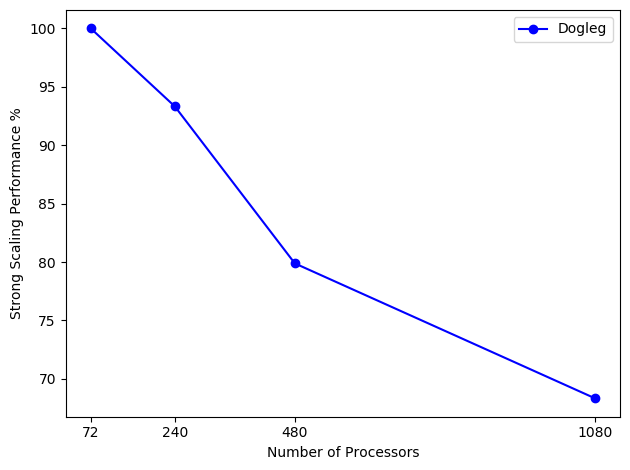

In [3]:
# Strong scaling plot
fig2, ax2 = plt.subplots()
fig2.canvas.set_window_title('Strong scaling dogleg problem')
sc_dogleg = dogleg.get_strong_scaling(CORES)
ax2.plot(CORES, sc_dogleg, label='Dogleg', marker='o', color='blue')

ax2.set(xlabel='Number of Processors', ylabel='Strong Scaling Performance %')
ax2.set_xticks(CORES)
ax2.legend()
fig2.tight_layout()
# fig2.savefig(fname)
fig2.show()

 ## Get the mean and mode of node distribution for partition
###############################################################################

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


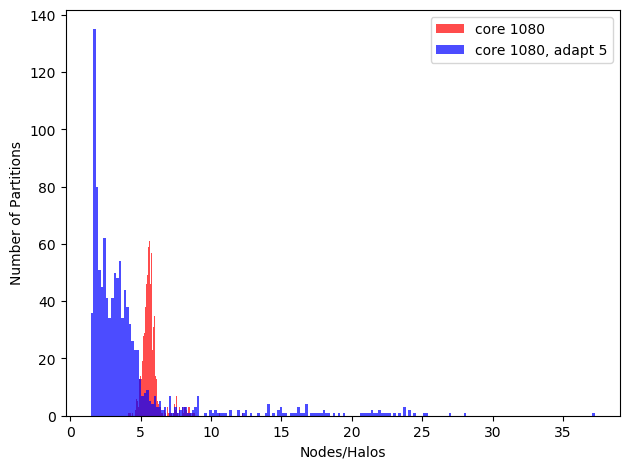

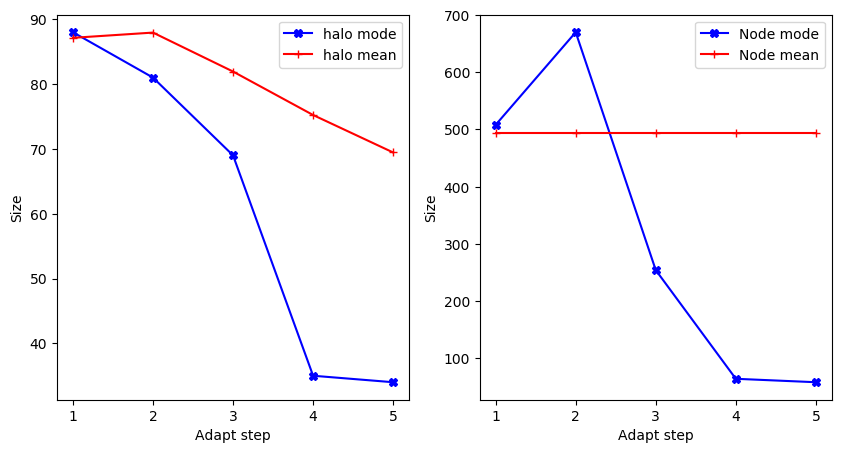

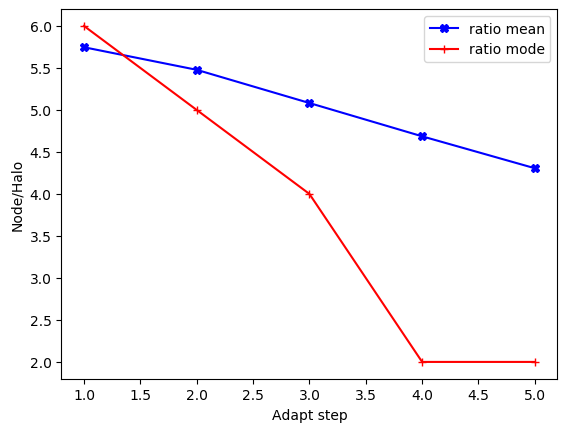

In [4]:
halo_mean, halo_mode, halos = dogleg.get_halo_stats(dir_dogleg,
                                                    f_dogleg_name,
                                                    MAX_ADAPT, CORES[-1])
node_mean, node_mode, nodes = dogleg.get_partition_stats(dir_dogleg,
                                                         f_dogleg_name,
                                                         MAX_ADAPT, CORES[-1])
# Print histogram statistics
fig1, ax1 = plt.subplots()
ax1.hist(nodes[0::MAX_ADAPT]/halos[0::MAX_ADAPT], 200,
         label='core 1080', color='red', alpha=0.7)
ax1.hist(nodes[4::MAX_ADAPT]/halos[4::MAX_ADAPT], 200,
         label='core 1080, adapt 5', color='blue', alpha=0.7)

ax1.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
ax1.legend()
fig1.tight_layout()
# fig1.savefig(fname)
fig1.show()

# Print halo statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(1, MAX_ADAPT+1), halo_mode,
         label='halo mode', color='blue', marker='X')
ax1.plot(range(1, MAX_ADAPT+1), halo_mean,
         label='halo mean', color='red', marker='+')
ax1.set(xlabel='Adapt step', ylabel='Size')
ax1.legend()

# Print node statistics 
ax2.plot(range(1, MAX_ADAPT+1), node_mode,
         label='Node mode', color='blue', marker='X')
ax2.plot(range(1, MAX_ADAPT+1), node_mean,
         label='Node mean', color='red', marker='+')
ax2.set(xlabel='Adapt step', ylabel='Size')
ax2.legend()
fig.show()

# Calculate the mode of Node/Halo vs Mean
ratio_mean, ratio_mode = dogleg.get_node_to_halo_ratio_stats(
    dir_dogleg, f_dogleg_name, MAX_ADAPT, CORES[-1])
fig, ax = plt.subplots()
ax.plot(range(1, MAX_ADAPT+1), ratio_mean,
        label='ratio mean', color='blue', marker='X')
ax.plot(range(1, MAX_ADAPT+1), ratio_mode,
        label='ratio mode', color='red', marker='+')
ax.set(xlabel='Adapt step', ylabel='Node/Halo')
ax.legend()
fig.show()

################################################################################
################################################################################
############################### BRUNNER ########################################
################################################################################
################################################################################

 # BRUNNER LATTICE PROBLEM

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


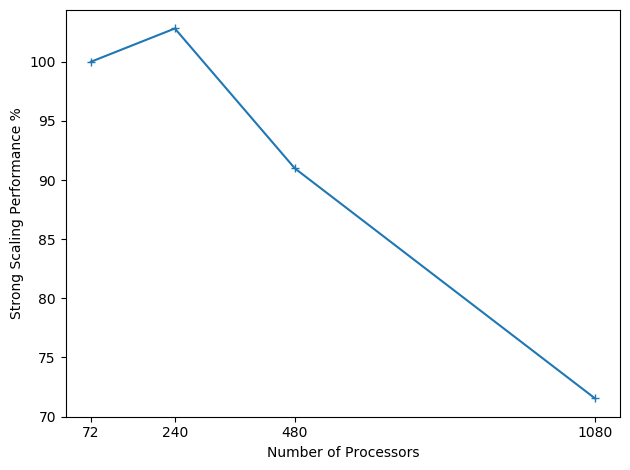

In [5]:
fig2, ax2 = plt.subplots()
fig2.canvas.set_window_title('Strong scaling brunner problem')
sc_brunner = brunner.get_strong_scaling(CORES)

ax2.plot(CORES, sc_brunner, label='strong scaling', marker='+')
ax2.set(xlabel='Number of Processors', ylabel='Strong Scaling Performance %')
ax2.set_xticks(CORES)
# ax2.legend()
fig2.tight_layout()
# fig2.savefig(fname)
fig2.show()  # %%


 ## Get the mean and mode of node distribution for partition
###############################################################################

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


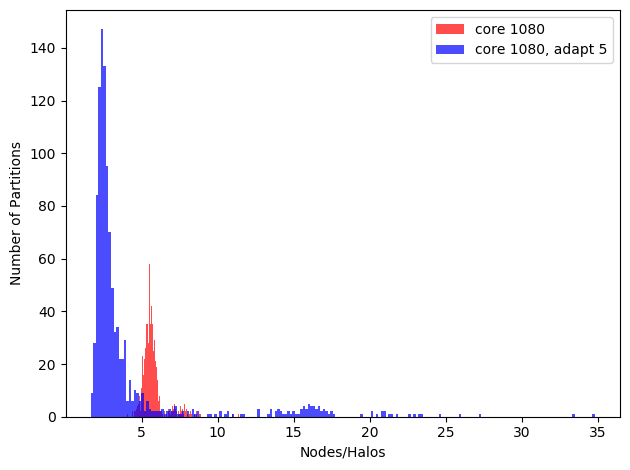

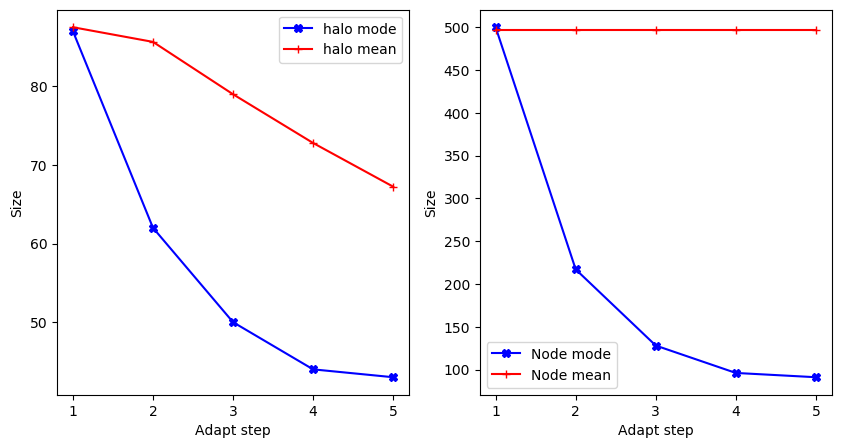

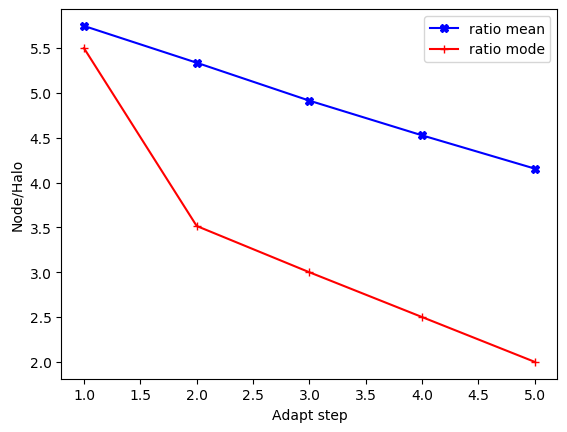

In [6]:
halo_mean, halo_mode, halos = brunner.get_halo_stats(dir_brunner,
                                                     f_brunner_name,
                                                     MAX_ADAPT, CORES[-1])
node_mean, node_mode, nodes = brunner.get_partition_stats(dir_brunner,
                                                          f_brunner_name,
                                                          MAX_ADAPT, CORES[-1])

# Plot histogram distribution o nodes/halos ratio
fig1, ax1 = plt.subplots()
ax1.hist(nodes[0::MAX_ADAPT]/halos[0::MAX_ADAPT], 200,
         label='core 1080', color='red', alpha=0.7)
ax1.hist(nodes[4::MAX_ADAPT]/halos[4::MAX_ADAPT], 200,
         label='core 1080, adapt 5', color='blue', alpha=0.7)

ax1.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
ax1.legend()
fig1.tight_layout()
# fig1.savefig(fname)
fig1.show()

# Print statistics for halos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(1, MAX_ADAPT+1), halo_mode,
         label='halo mode', color='blue', marker='X')
ax1.plot(range(1, MAX_ADAPT+1), halo_mean,
         label='halo mean', color='red', marker='+')
ax1.set(xlabel='Adapt step', ylabel='Size')
ax1.legend()

# Print statistics for node partitions
ax2.plot(range(1, MAX_ADAPT+1), node_mode,
         label='Node mode', color='blue', marker='X')
ax2.plot(range(1, MAX_ADAPT+1), node_mean,
         label='Node mean', color='red', marker='+')
ax2.set(xlabel='Adapt step', ylabel='Size')
ax2.legend()

fig.show()

# Calculate the mode of Node/Halo vs Mean
ratio_mean, ratio_mode = brunner.get_node_to_halo_ratio_stats(
    dir_brunner, f_brunner_name, MAX_ADAPT, CORES[-1])
fig, ax = plt.subplots()
ax.plot(range(1, MAX_ADAPT+1), ratio_mean,
        label='ratio mean', color='blue', marker='X')
ax.plot(range(1, MAX_ADAPT+1), ratio_mode,
        label='ratio mode', color='red', marker='+')
ax.set(xlabel='Adapt step', ylabel='Node/Halo')
ax.legend()
fig.show()